# Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).
<p> <b>Data description </b></p>
<p>● city: city this user signed up in </p>
<p>● phone: primary device for this user </p>
<p>● signup_date: date of account registration; in the form ‘YYYY MM DD’ </p>
<p>● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’</p>
<p>● avg_dist: the average distance in miles per trip taken in the first 30 days after signup</p>
<p>● avg_rating_by_driver: the rider’s average rating over all of their trips</p>
<p>● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips</p>
<p>● surge_pct: the percent of trips taken with surge multiplier > 1</p>
<p>● avg_surge: The average surge multiplier over all of this user’s trips</p>
<p>● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up</p>
<p>● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise</p>
<p>● weekday_pct: the percent of the user’s trips occurring during a weekday </p>

In [192]:
%matplotlib inline
import pandas as pd
import datetime as dt
import numpy as np
import json
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [35]:
data_challenge = json.load((open('ultimate_data_challenge.json')))
challenge_df = pd.DataFrame(data_challenge)
print(challenge_df.info())
challenge_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [9]:
challenge_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [39]:
#check to determine all last_trip_date are in the correct format. 
import datetime
ind = challenge_df.last_trip_date.unique()
sign = challenge_df.signup_date.unique()

def valid_date(date):
    for i in date:
        try:
            datetime.datetime.strptime(str(i), '%Y-%m-%d')
        except ValueError:
            raise ValueError("Incorrect data format, should be YYYY-MM-DD")
    return('all good')
print('signup_date is ' + valid_date(sign)+' and last trip date is ' + valid_date(ind))

signup_date is all good and last trip date is all good


We have missing data in ratings by the driver and of the driver, and in the primary device of the user. 

In [40]:
challenge_df['last_trip_date'] = challenge_df['last_trip_date'].astype('datetime64[ns]')
challenge_df['signup_date'] = challenge_df['signup_date'].astype('datetime64[ns]')
challenge_df2 = challenge_df.sort_values(by='last_trip_date', ascending=False)
challenge_df2.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
4486,11.94,5.0,5.0,1.00,Winterfell,2014-07-01,Android,2014-01-25,0.0,4,True,25.0
43047,5.49,4.7,5.0,1.01,King's Landing,2014-07-01,iPhone,2014-01-15,0.8,1,True,89.3
24059,8.62,4.9,4.3,1.11,Astapor,2014-07-01,iPhone,2014-01-24,14.3,1,False,71.4
40290,7.51,4.8,4.9,1.02,King's Landing,2014-07-01,iPhone,2014-01-07,1.6,2,True,95.2
28689,16.32,5.0,5.0,1.00,King's Landing,2014-07-01,iPhone,2014-01-16,0.0,5,False,75.0
41544,3.16,4.8,5.0,1.11,Winterfell,2014-07-01,iPhone,2014-01-22,12.7,7,True,52.1
44457,2.34,4.7,4.8,1.00,Winterfell,2014-07-01,iPhone,2014-01-13,0.0,9,False,91.7
21699,4.35,4.7,3.4,1.00,Winterfell,2014-07-01,iPhone,2014-01-13,0.0,4,True,66.7
15631,3.29,4.9,4.5,1.15,King's Landing,2014-07-01,iPhone,2014-01-15,27.8,0,False,91.7
33653,7.55,5.0,4.3,1.00,Winterfell,2014-07-01,iPhone,2014-01-07,0.0,1,True,50.0


In [200]:
challenge_df3 = challenge_df2.copy()
challenge_df3.set_index('last_trip_date', inplace=True)
challenge_df3['retained'] = challenge_df3.index >= '2014-05-31'
challenge_df3.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
last_trip_date,,,,,,,,,,,,
2014-07-01,11.94,5.0,5.0,1.00,Winterfell,Android,2014-01-25,0.0,4,True,25.0,True
2014-07-01,5.49,4.7,5.0,1.01,King's Landing,iPhone,2014-01-15,0.8,1,True,89.3,True
2014-07-01,8.62,4.9,4.3,1.11,Astapor,iPhone,2014-01-24,14.3,1,False,71.4,True
2014-07-01,7.51,4.8,4.9,1.02,King's Landing,iPhone,2014-01-07,1.6,2,True,95.2,True
2014-07-01,16.32,5.0,5.0,1.00,King's Landing,iPhone,2014-01-16,0.0,5,False,75.0,True


In [201]:
challenge_df3['date_check'] = challenge_df3.index > challenge_df3.signup_date
print(sum(challenge_df3.date_check) / challenge_df3.date_check.count())
#a check to make sure that all of the dates were not recorded wrong because a driver could not have their last 
# ride prior to signing up. it is interesting that 4.7% of customers only took the single ride on their first 
# day of signing up. 
challenge_df3[challenge_df3.index < challenge_df3.signup_date]

0.95396


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,date_check
last_trip_date,,,,,,,,,,,,,


In [202]:
challenge_df3['n'] = 1
imp_columns = challenge_df3.loc[:,['n','retained']]
daily = imp_columns.resample('D').sum()
daily['binary_retained'] = daily.retained > 0
daily = daily.drop('retained', axis=1)
daily.head()

,n,binary_retained
last_trip_date,,
2014-01-01,128,False
2014-01-02,180,False
2014-01-03,128,False
2014-01-04,199,False
2014-01-05,270,False


In [252]:
onemonth_subset = daily.loc['2014-02-01':'2014-03-01']

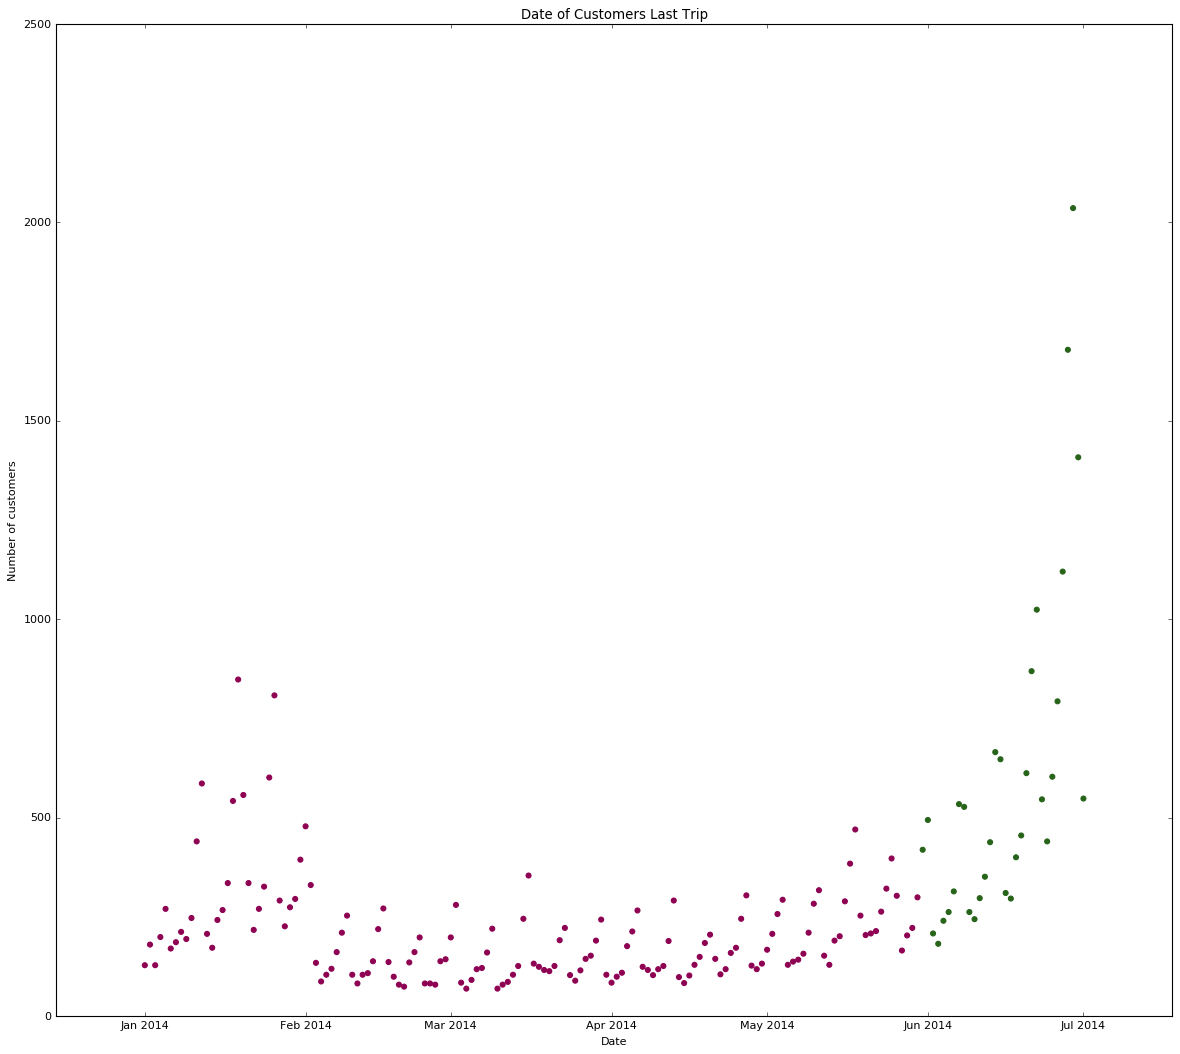

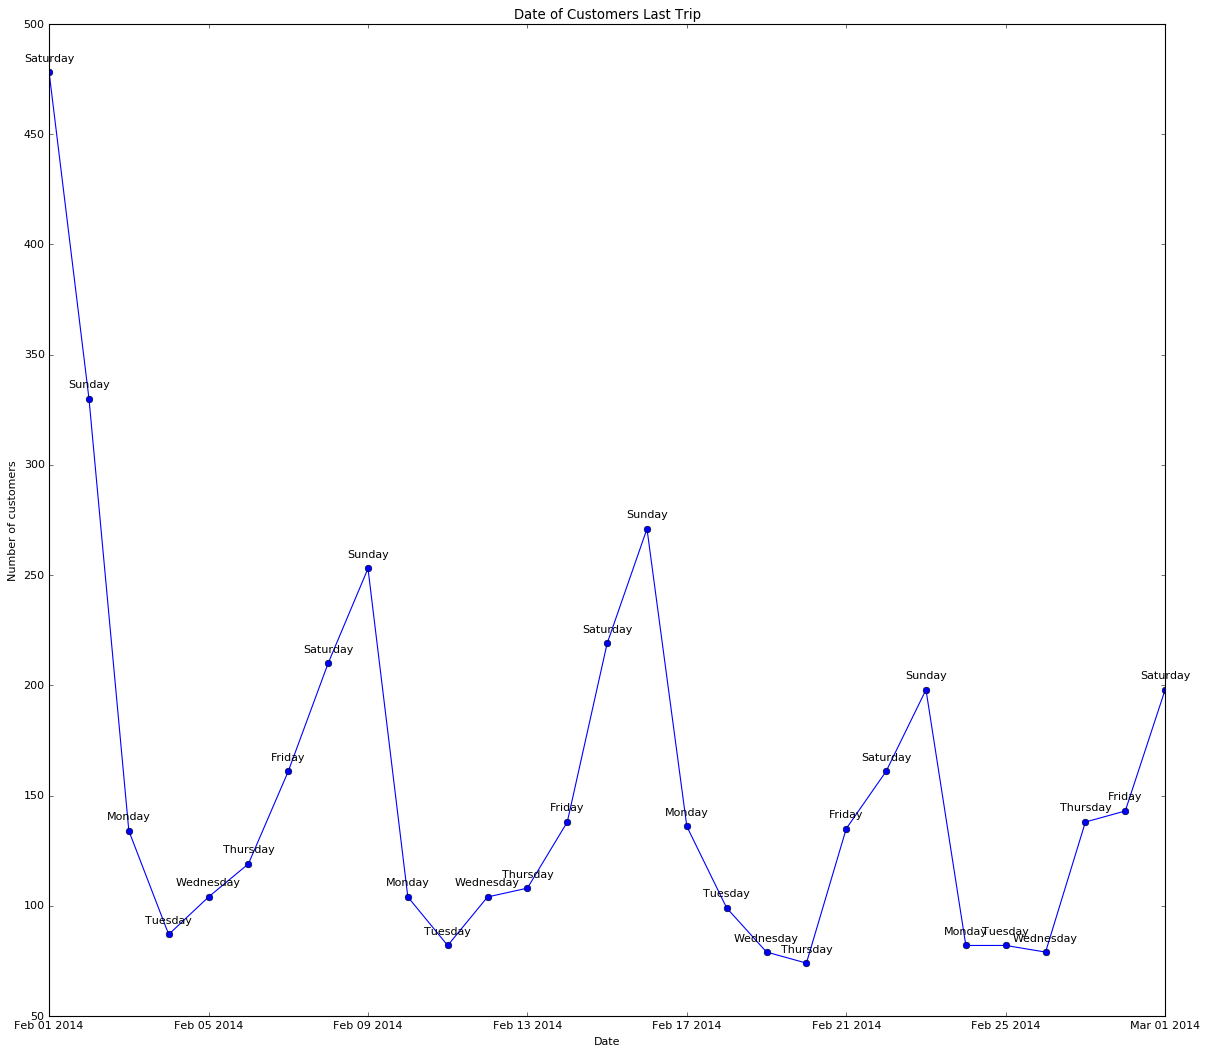

In [204]:
_= plt.figure(figsize=(18,16), dpi=80,facecolor='w',edgecolor='k')
_= plt.scatter(daily.index, daily.n, c=daily.binary_retained, cmap='PiYG',edgecolors='face')
_= plt.xlabel('Date')
_= plt.ylabel('Number of customers')
_= plt.ylim(0,2500)
_= plt.title('Date of Customers Last Trip')
_= plt.show()

_= plt.figure(figsize=(18,16), dpi=80,facecolor='w',edgecolor='k')
_= plt.plot(onemonth_subset.index, onemonth_subset.n, marker='o')
for x,y in zip(onemonth_subset.index, onemonth_subset.n):
    label= x.day_name()
    _= plt.annotate(label, (x,y),textcoords='offset points',xytext=(0,10),ha='center')
_= plt.xlabel('Date')
_= plt.ylabel('Number of customers')
_= plt.title('Date of Customers Last Trip')
_= plt.show()

The first month is a volatile time for customers to not come back to use the service. After the first month the number of people who decide to no longer use the service decreases but there is a definite cyclic pattern to the customers using the driving service. The date of their last ride tends to be on Sunday. However, the company doesn't ahve to worry too much about people leaving during the week, it is on the weekend that people will book there last ride. It would be interesting to see the general ridership over the week and see how this compares to when the customers leave. If the rides typically happen over the weekend then it would make sense that there last day was on the weekend and then they decided not to use the service any longer so that is when the last day occurred. 

In [205]:
# a look into the number of customers per city, there is almost 10,000 more users in Winterfell then King's 
# Landing
challenge_df3.groupby('city').n.sum()

city
Astapor           16534
King's Landing    10130
Winterfell        23336
Name: n, dtype: int64

In [206]:
#average retention rate for January cohort = 38.446%
sum(challenge_df3.retained)/challenge_df3.retained.count()

0.38446

I am going to use a Binary Classification model in order to predict whether a person will still use the service after 6 months. I will use avg mileage, avg rating of driver, avg rating from driver. Then I will test these variables with other models including the other variables to see if they have any effect on the strength of the model to correctly classify a customer. I will also use regularization techniques to combat the effect of adding additional variables to the model. 

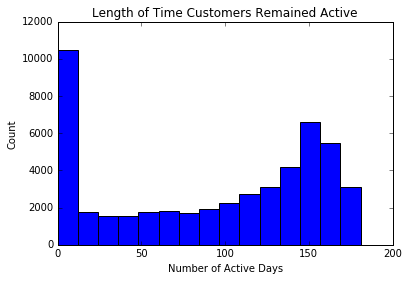

In [207]:
#first, the date must be transformed into days since signup. 
challenge_df3['days_since_signup'] = challenge_df3.index - challenge_df3.signup_date
plt.hist(challenge_df3.days_since_signup.dt.days, bins=15)
plt.xlabel('Number of Active Days')
plt.ylabel('Count')
plt.title('Length of Time Customers Remained Active')
plt.show()


2302
            days_since_signup  trips_in_first_30_days
count                   13027            13027.000000
mean   5 days 23:17:13.269363                1.888232
std    8 days 07:14:45.548640                1.820168
min           0 days 00:00:00                1.000000
25%           1 days 00:00:00                1.000000
50%           1 days 00:00:00                1.000000
75%           8 days 00:00:00                2.000000
max          30 days 00:00:00               33.000000


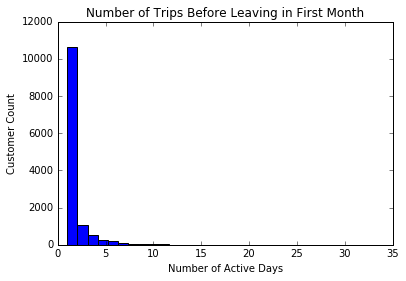

In [208]:
print(sum(challenge_df3.days_since_signup.dt.days==0))
first_mo = challenge_df3[challenge_df3.days_since_signup.dt.days < 31]
print(first_mo.loc[:,['days_since_signup','trips_in_first_30_days']].describe())
plt.hist(first_mo['trips_in_first_30_days'], bins=30)
plt.xlabel('Number of Active Days')
plt.ylabel('Customer Count')
plt.title('Number of Trips Before Leaving in First Month')
plt.show()

In [209]:
first_mo[first_mo.trips_in_first_30_days == 33]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,date_check,n,days_since_signup
last_trip_date,,,,,,,,,,,,,,,
2014-02-07,2.29,4.9,4.9,1.13,Astapor,iPhone,2014-01-22,18.2,33,True,63.6,False,True,1,16 days
2014-02-03,1.78,4.5,3.2,1.00,Winterfell,iPhone,2014-01-11,0.0,33,True,100.0,False,True,1,23 days


These past two cells show that the majority of people who are leaving in the first month only use the service once or twice and decide that it is not for them and decide not to use it anymore. However, there are a few outliers, explicitly the two in the previous cell where one person did 33 trips in 16 days while the other did the same in 23. One makes sense because s/he used it to get to work on a daily basis for 23 days and then decided to not go with the service anymore. Just interesting how they could use the service so much in under 30 days but then decide that it is not for them. Either that or there is some sort of error where the tracking system messed up on these two individuals. Or these two individuals were kicked out of their account and forced to re-create an account. 

However, the point is that the first or second drive that the customer uses is extremely influential on whether they come back. Therefore, trying to make their first experience the best it can be, might be helpful for retaining customers just to get past the try it once and never use it again. Thus, I may suggest to the company before building any model that they should try to use some type of marketing scheme to keep people using the service for more than that first time. I am not sure what the marketing ploys of surge and ultimate_black_user meant in terms of what was being offered to the customer, but both of the customers that used it 33 times in 30 days and then left were both ultimate_black_users and one of the two used the surge. 

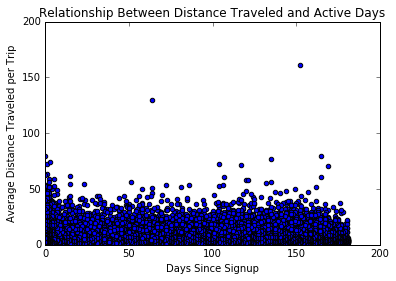

In [210]:
#use: avg_dist, 
_= plt.scatter(challenge_df3.days_since_signup.dt.days, challenge_df3.avg_dist)
_=plt.xlabel('Days Since Signup')
_= plt.xlim(0,)
_= plt.ylabel('Average Distance Traveled per Trip')
_= plt.ylim(0,)
_= plt.title('Relationship Between Distance Traveled and Active Days')
_= plt.show()

In [211]:
challenge_df3['days'] = challenge_df3.days_since_signup.dt.days
ratings_days_driver = challenge_df3.loc[:, ['avg_rating_by_driver', 'days']]
ratings_days_customer = challenge_df3.loc[:, ['avg_rating_of_driver', 'days']]
driver_rating = ratings_days_driver.groupby('avg_rating_by_driver').mean()
customer_rating = ratings_days_customer.groupby('avg_rating_of_driver').mean()

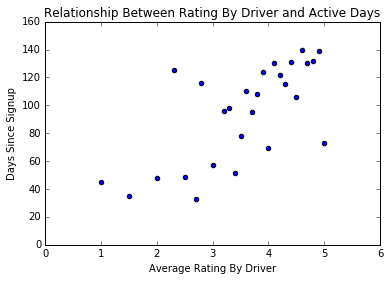

In [212]:
_= plt.scatter(driver_rating.index, driver_rating.days)
_=plt.xlabel('Average Rating By Driver')
_= plt.xlim(0,)
_= plt.ylabel('Days Since Signup')
_= plt.ylim(0,)
_= plt.title('Relationship Between Rating By Driver and Active Days')
_= plt.show()

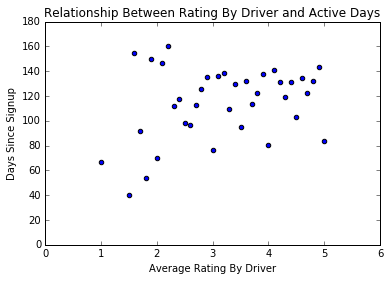

In [213]:
_= plt.scatter(customer_rating.index, customer_rating.days)
_=plt.xlabel('Average Rating By Driver')
_= plt.xlim(0,)
_= plt.ylabel('Days Since Signup')
_= plt.ylim(0,)
_= plt.title('Relationship Between Rating By Driver and Active Days')
_= plt.show()

I need to do a Linear Support Vector Machine, Decision Tree, Logistic Regression

First I am going to check for correlation between any of the features

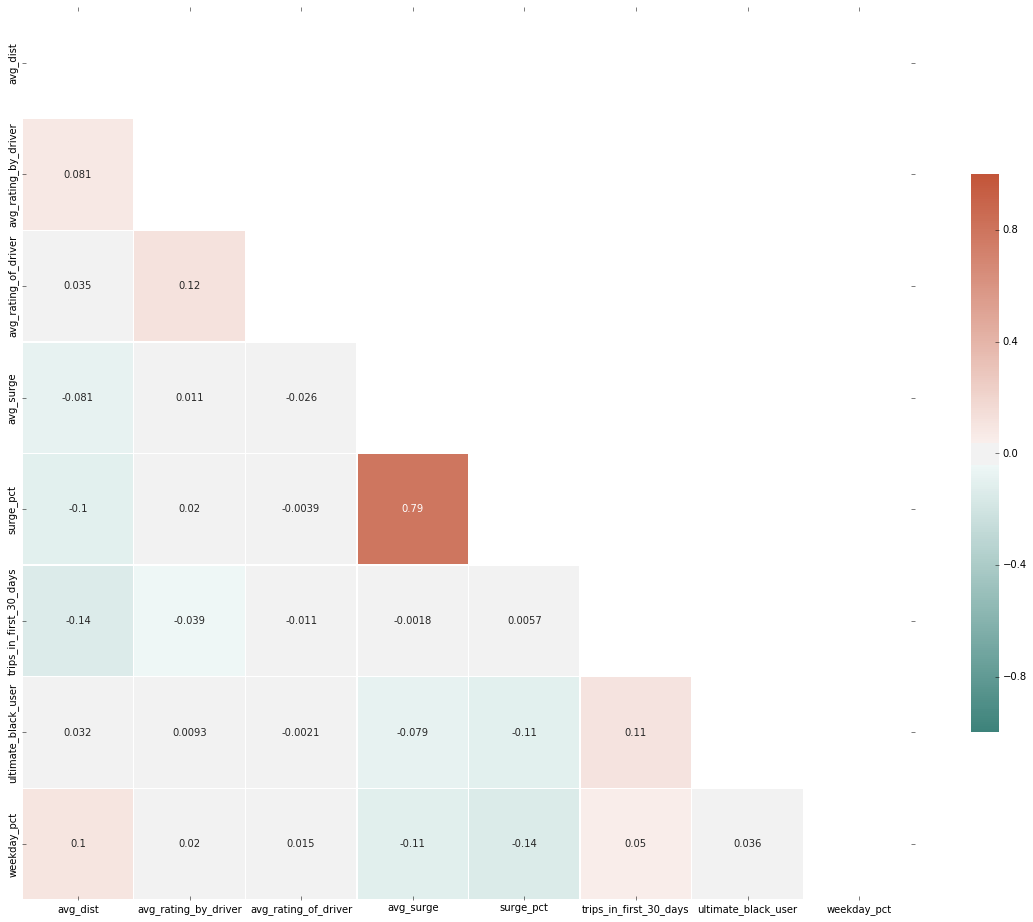

In [215]:
correlation = challenge_df.corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

due to the high correlation between surge % and average surge I will be keeping surge percentage as it may pertain to retention rate more than avg_surge; however, they are highly correlated so should produce similar results. 

In [234]:
manip_data = challenge_df3.copy()
manip_data1 = manip_data.drop(['date_check', 'n', 'days_since_signup', 'signup_date','city', 'phone',], axis=1)
manip_data2 = manip_data1.dropna(axis=0)

In [235]:
x = manip_data2[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
       'surge_pct', 'trips_in_first_30_days','ultimate_black_user', 'weekday_pct', 'days']]
y = manip_data2.retained

In [239]:
import warnings
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

xtr, xtest, ytr, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [240]:
# Linear Support Vector Machine
warnings.filterwarnings("ignore")
svm = LinearSVC()
scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(svm, xtr, ytr, scoring=scoring, cv=20)
sorted(scores.keys())
SVC_fit_time = scores['fit_time'].mean()
SVC_score_time = scores['score_time'].mean()
SVC_accuracy = scores['test_accuracy'].mean()
SVC_precision = scores['test_precision_macro'].mean()
SVC_recall = scores['test_recall_macro'].mean()
SVC_f1 = scores['test_f1_weighted'].mean()
SVC_roc = scores['test_roc_auc'].mean()

In [242]:
lr = LogisticRegression()
scores = cross_validate(lr, xtr, ytr, scoring=scoring, cv=20)
sorted(scores.keys())
lr_fit_time = scores['fit_time'].mean()
lr_score_time = scores['score_time'].mean()
lr_accuracy = scores['test_accuracy'].mean()
lr_precision = scores['test_precision_macro'].mean()
lr_recall = scores['test_recall_macro'].mean()
lr_f1 = scores['test_f1_weighted'].mean()
lr_roc = scores['test_roc_auc'].mean()

In [243]:
tree = DecisionTreeClassifier()
scores = cross_validate(tree, xtr, ytr, scoring=scoring, cv=20)
sorted(scores.keys())
tree_fit_time = scores['fit_time'].mean()
tree_score_time = scores['score_time'].mean()
tree_accuracy = scores['test_accuracy'].mean()
tree_precision = scores['test_precision_macro'].mean()
tree_recall = scores['test_recall_macro'].mean()
tree_f1 = scores['test_f1_weighted'].mean()
tree_roc = scores['test_roc_auc'].mean()

In [244]:
nb = GaussianNB()
scores = cross_validate(nb, xtr, ytr, scoring=scoring, cv=20)
sorted(scores.keys())
nb_fit_time = scores['fit_time'].mean()
nb_score_time = scores['score_time'].mean()
nb_accuracy = scores['test_accuracy'].mean()
nb_precision = scores['test_precision_macro'].mean()
nb_recall = scores['test_recall_macro'].mean()
nb_f1 = scores['test_f1_weighted'].mean()
nb_roc = scores['test_roc_auc'].mean()

In [246]:
models_initial = pd.DataFrame({
    'Model'       : ['Support Vector Machine', 'Logistic Regression', 'Decision Tree', 'Bayes'],
    'Fitting time': [SVC_fit_time, lr_fit_time, tree_fit_time, nb_fit_time],
    'Scoring time': [SVC_score_time, lr_score_time, tree_score_time, nb_score_time],
    'Accuracy'    : [SVC_accuracy, lr_accuracy, tree_accuracy, nb_accuracy],
    'Precision'   : [SVC_precision, lr_precision, tree_precision, nb_precision],
    'Recall'      : [SVC_recall, lr_recall, tree_recall, nb_recall],
    'F1_score'    : [SVC_f1, lr_f1, tree_f1, nb_f1],
    'AUC_ROC'     : [SVC_roc, lr_roc, tree_roc, nb_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 
                  'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
1,Logistic Regression,1.202742,0.034478,0.956639,0.954593,0.956733,0.956690,0.993949
2,Decision Tree,0.138471,0.038776,0.940918,0.939567,0.939103,0.940901,0.939103
3,Bayes,0.075276,0.043230,0.933342,0.930774,0.932856,0.933421,0.978040
0,Support Vector Machine,8.171849,0.039940,0.928703,0.937087,0.923367,0.927264,0.993220


Out of the four models used in this analysis, Logistic Regression model performed the best. Now I will tune the model. 

In [248]:
lr.fit(xtr,ytr)
accuracy_score(lr.predict(xtest), ytest)

0.9544855671337885

It performed very well on the never before seen testing data that was split off originally. 

<b>Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. </b>

With the logistic regression model, I would be able to predict from a cohort that signed up, I would be able to accurately predict 95% of the time given the features used in this model whether they would still be usingn the service in the 6th month. I considered three other alternative models: Decision Trees, Naive Bayes, and Support Vector Machine. These models did not perform as well as logistic regression in Accuracy, precision, recall, f1-score, and the AUC ROC. I believe that the model is quite valid considering its ability to accurately predict new test data. I am a little concerned by the AUC ROC average value for the logistic regression model being too high, it may fit this data very well, but may not fit data taken from a cohort that started in a different month. There could be a seasonality associated with when people signed up in January. There may be something with the new year that might cause more people to try to start something, but not keep it up, like going to the gym. Not quite that drastic, but it could be something similar. 

<b>Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention</b>

I believe that Ultimate could use this model upon a new cohort that started in a different month and determine whether the customers stay or not. They could then use the data from the first month to predict where to place their marketing efforts. If a person has signed up for the service but has only used the service once in the first month, they may try to send them an individualized promotion to try to get them to remain active with using Ultimate. 